# Localización de un agente usando Viterbi

Revisado el algoritmo de Viterbi en una aplicación común como es el etiquetado de cadenas de lenguaje natural, podemos ver que los Modelos Ocultos de Markov pueden servir para otras aplicaciones. Aquí, nos enfocamos en mostrar cómo se puede usar un modelo oculto de Markov junto con el algoritmo de Viterbi para poder definir la localización de un agente. En primer lugar planteamos el problema.

### Planteamiento del problema

Supongamos que tenemos un agente que se encuentra en algún lugar de un laberinto/mapa. Sin embargo, el agente no conoce el mapa y, por tanto, desconoce su ubicación actual. Pero el agente cuenta con sensores que le permiten ver lo que pasa hay a su alrededor. En particular, puede determinar si arriba, abajo, a la izquierda o a la derecha se encuentra un obstáculo o no.

Por tanto, comenzaremos por plantear un mapa y colocar al agente en una posición del mapa. Si bien podemos ver en esta simulación donde se encuentra el agente, el agente mismo no sabe su posición.

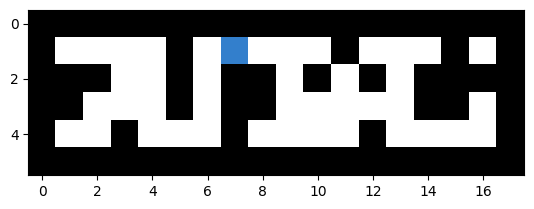

(7, 1)


In [1]:
from maze_simulator import Maze
from copy import deepcopy
import numpy as np
import pandas as pd
np.random.seed(12345)

mapa = """
##################
#    # o   #   # #
###  # ## # # ####
##   # ##     ## #
#  #   #    #    #
##################
"""

maze = Maze(mapa)
maze.draw()
print(maze.initial)

#### Sensor del agente

La información del agente le será dada por un sensor que le permitirá saber dónde hay obstáculos. En particular, el sensor codificará los alrededores del agente por medio de un vector con 4 entradas. Cada entrada representa una dirección posibles. Este vector será de la forma:

$$p_i = [A,B,I,D]$$

Donde A representa arriba, B abajo, I izquierda y D derecha. El vector tomará entradas binarias. Así por ejemplo una percepción del tipo [0,1,1,0] representará que el agente percibe que sólo puede avanzar hacia abajo y hacia la izquierda (las entradas con 1), mientras que arriba y derecha están bloqueadas. 

In [2]:
def sensor(agent):
    """Sensor del agente"""
    percept = []
    for action in ["up","down","left","right"]:
        newx, newy = agent.result(agent.initial, action)
        if agent.board[newy][newx] != "#":
            percept.append(1)
        else:
            percept.append(0)
    return np.array(percept)

En su posición actual, la percepción que tiene el agente a partir de su sensor es la siguiente:

In [3]:
sensor(maze)

array([0, 0, 1, 1])

## Modelo Oculto de Markov

Construiremos, con ayuda de los Modelos Ocultos de Markov, un agente basado en modelos. Este agente contará con dos modelos:

1. Modelo del mundo o modelo de transiciones, el cuál registrará que posibles estados son posibles desde cada estado dado. 
2. Modelo sensor o modelo de observaciones, que registra la probabilidad de que una percepción pertenezca a una localización particular.

En este caso, la localización depende de las coordenadas en las que se localiza el agente $(x,y)$. Además, para evitar una sobrecarga de localizaciones, únicamente tomamos en cuenta aquellas localizaciones en que sí puede estar el agente; es decir, aquellas localizaciones con obstáculos se descartan.

Finalmente, guardamos los valores de entrada y los valores de salida para el Modelo Oculto de Márkov. En este caso, cada coordenada es indexada con un valor de entero positivo. Así por ejemplo la coordenada (0,0) será el valor $y_0 = 0$. Esto lo hacemos para trabajar con estos valores de forma más eficiente.

In [4]:
#Posiciones posibles
positions = {}

#Obtiene sólo las posiciones que no son negros #
for i,row in enumerate(maze.board):
    for j, column in enumerate(row):
        if column != '#':
            percept = []
            for action in ["up","down","left","right"]:
                newx, newy = maze.result((j,i), action)
                if maze.board[newy][newx] != "#":
                    percept.append(1)
                else:
                    percept.append(0)
            positions[(j,i)] = np.array(percept)
            
#Número de posiciones posibles
n = len(positions)
#Índices para las posiciones
indxs = {i:pos for i,pos in enumerate(positions.keys())}
inv_indxs = {pos:i for i,pos in indxs.items()}

### Modelo del mundo

El modelo de transición (del mundo) consistirá en las probabilidades de la forma $p(y_j|y_i)$, que refieren a la probabilidad de transitar (de que el agente se mueva), de la posición $y_i$ hacia la posición $y_j$. Entonces nuestra matriz de transición contendrá esta información. Las probabilidades están determinadas de la siguiente forma:

$$p(y_j|y_i) = \begin{cases} 0 & \text{si } y_j \text{ es obstáculo} \\ \frac{1}{n} & \text{otro cas} \end{cases}$$

Aquí $n$ representa el número de estados siguientes a los que se puede mover el agente; es decir, aquellos que son agentes.

In [5]:
#Creación de la matriz de transiciones
A = np.zeros((n,n))
for pos in positions.keys():
    k = inv_indxs[pos]
    total = 0
    for action in maze.actions(pos):
        l = inv_indxs[maze.result(pos, action)] 
        A[l,k] = 1
        total += 1
    
    if total != 0:
        A[:,k] = A[:,k]/total
    
pd.DataFrame(data=A, index=[str(p) for p in positions.keys()], columns=[str(p) for p in positions.keys()])

,"(1, 1)","(2, 1)","(3, 1)","(4, 1)","(6, 1)","(7, 1)","(8, 1)","(9, 1)","(10, 1)","(12, 1)",...,"(5, 4)","(6, 4)","(8, 4)","(9, 4)","(10, 4)","(11, 4)","(13, 4)","(14, 4)","(15, 4)","(16, 4)"
"(1, 1)",0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(2, 1)",1.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(3, 1)",0.0,0.5,0.000000,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(4, 1)",0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(6, 1)",0.0,0.0,0.000000,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(7, 1)",0.0,0.0,0.000000,0.0,0.5,0.0,0.5,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(8, 1)",0.0,0.0,0.000000,0.0,0.0,0.5,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(9, 1)",0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.000000,1.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(10, 1)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(12, 1)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


### Modelo sensor

El modelo sensor o modelo de observaciones determina la probabilidad de que dada una percepción $[A,B,I,D]$ el agente se encuentre en cierta posición $(x,y)$. Para estimar estas probabilidades, esto depende de que las semejanzas entre los posibles movimientos que tenga que hacer el agente. Por ejemplo, si la posición tiene un obstáculo arriba y otro abajo, coincidirá con las percepciones $[1,1,0,0]$, por lo que si la percepción es ésta, sólo tendrán probabilidad aquellos elementos que coincidan con estos casos. Sin embargo, asumiremos que las lecturas del sensor pueden tener un error $\epsilon$ de tal forma que nuestras probabilidades estarán dadas como:

$$p(x_j|y_i) = (1-\epsilon)^{(4-d_{i,j})}\epsilon^d_{i,j}$$

donde $d_{i,j}$ son el número de elementos distintos entre el vector de percepción y el vector de la posición, es decir, un vector formado por [A,B,I,D] que corresponde a la posición. Por ejemplo, si la posición $(1,1)$ tiene sólo una posible salida hacia la derecha, su vector será [0,0,0,1], mientras que si la percepción es [0,1,0,1] entonces $d_{i,j} = 1$, pues sólo difieren en el segundo elemento (0 y 1). Si tomamos $\epsilon = \frac{1}{2}$, entonces la probabilidad de que la posición genere la percepción sería $\frac{1}{2}^3\frac{1}{2} = \frac{1}{16}$.

In [6]:
def B(perception, eps=1e-3):
    """Función para estimar probabilidades del modelo sensor"""
    probs = []
    for pos, val in positions.items():
        d_ij = (1*(val != perception)).sum()
        p = ((1-eps)**(4-d_ij))*(eps**(d_ij))
        probs.append(p)
        
    return np.array(probs)

### Exploración

Para determinar con mayor precisión la localización del agente no basta con la percepción que este tenga en el estado actual. Pues como hemos descrito, una percepción de la forma [0,0,0,1] (donde el único movimiento posible es a la derecha), tiene una probabilidad igual en todas las posiciones que tengan esta lectura; es decir, en todas aquellas partes del mapa donde el agente puede moverse solo a la derecha. 

Por tanto, es necesario que el agente explore los alrededores de su locación actual para generar una secuencia de percepciones que no sólo le permitan saber la posición actual, sino los diferentes movimientos que tiene desde la posición actual. Esto ayuda a desambiguar la posición en que se encuentra el agente, pues si bien pueden existir diferentes posiciones con las mismas percepciones, estas posiciones varían por sus alrededores y explorar estos alrededores ayudará al agente a localizarse.

Generamos por tanto una exploración en que el agente, a partir de su posición inicial se mueva por los caminos posibles, y en cada estado, por medio de sus sensores, genere percepciones. Obtendremos una secuencia de percepciones con la que, al aplicar algún algoritmo para Modelos Ocultos de Márkov, podremos conocer la posición del agente.

In [7]:
#Percepción inicial
seq = [sensor(maze)]
#Estado
state = maze.initial
#Para comparar, guardamos las localizaciones reales
#En una aplicación real esto no siempre es posible
real_path = [maze.initial]

agent2 = deepcopy(maze)
t = 0
#Generamos una secuencia de una longitud determinada
while t < 10:
    #Realiza un movimiento hacia una nueva localización
    action = np.random.choice(maze.actions(state))
    new_state = maze.result(state, action)
    #Evitamos que el agente se quede en la misma localización
    if new_state not in real_path:
        state = new_state
        real_path.append(state)
        agent2.initial = state
        seq.append(sensor(agent2))
        t += 1

print(seq)

[array([0, 0, 1, 1]), array([0, 1, 0, 1]), array([1, 1, 0, 0]), array([1, 1, 0, 0]), array([1, 0, 1, 0]), array([0, 0, 1, 1]), array([1, 0, 0, 1]), array([1, 1, 1, 0]), array([1, 0, 1, 1]), array([1, 1, 0, 1]), array([1, 1, 1, 0])]


## Algoritmo de Viterbi

Finalmente, ya con la secuencia de percepciones determinada, utilizamos el algoritmo de Viterbi para encontrar la secuencia de localizaciones que con mayor probabilidad le corresponda a la secuencia de percepciones obtenida. Recordamos que el algoritmo de Viterbi consta de dos pasos:

1. El paso de avance (forward), donde se obtienen el conjunto de variables $\delta_i(t)$ y $\phi_i(t)$ donde $i$ corresponde a un índice asociado, en este caso, a las localizaciones en el mapa y $t$ representa la percepción en el tiempo $t$ de la secuencia de percepciones. De tal forma que en cada tiempo $t$ tenemos que $$\delta_j(t) = \max_{i_1, i_2,...,i_t} p(y_{i_1}^{(1)},..., y_{i_{t-1}}^{(t-1)}, x^{(1)},...,x^{(t)}, y^{(t)}_j)$$ donde las $y_j^{(t)}$ representan la posición $j$ en el tiempo $t$ y $x_i^{(t)}$ es la $t$-ésima percepción del agente.
2. El paso de retroceso (backward), donde de los caminos resultantes se elige el que tenga la máxima probabilidad final y se recuperan las emisiones, que representan las localizaciones, que mejor se adaptan a las percepciones obtenidas.

El resultado de aplicar el algoritmo de Viterbi será entonces una secuencia de percepciones que buscan maximizar:

$$\hat{y}^{(1)}, \hat{y}^{(2)}, ...,\hat{y}^{(T)} = \arg\max_{i_1,...,i_T} p(y_{i_{1}}^{(1)}, y_{i_{2}}^{(2)},...,y_{i_{T}}^{(T)}, x_{i_{1}}^{(1)}, x_{i_{2}}^{(2)},...,x_{i_{T}}^{(T)} )$$

El resultado, entonces, es la siguiente secuencia de localizaciones:

In [8]:
from viterbi_localization import Viterbi

#Aplica el algoritmo de Viterbi
path = Viterbi(seq, (indxs,A,B), n=n)

print(path)

[(7, 1), (6, 1), (6, 2), (6, 3), (6, 4), (5, 4), (4, 4), (4, 3), (3, 3), (3, 2), (3, 1)]


#### Visualización de las secuencias

Para hacer más clara la salida que nos arroja el algoritmo de Viterbi, podemos ver en el mapa que hemos generado cuál es el camino predicho por el método:

Camino predicho


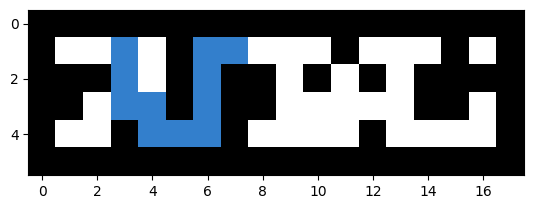

In [9]:
pred_path = deepcopy(maze)
pred_path
for x,y in path[::-1]:
    #x,y = indxs[predict]
    pred_path.board[y][x] = 'o'
    
print('Camino predicho')
pred_path.draw()

Finalmente, lo comparamos con el camino real hecho por el agente y de donde obtuvo las percepciones. Como podemos ver, aunque no siempre son idénticos, llegamos a obtener que la posición inicial en ambos casos coincide. Es decir, hemos predicho cuál es la posición en la que inició nuestro agente.

Camino real


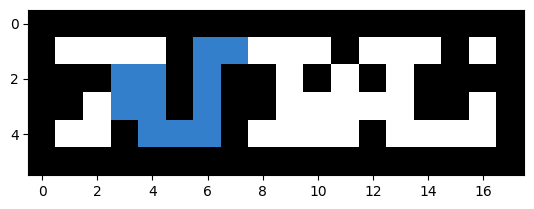

[(7, 1), (6, 1), (6, 2), (6, 3), (6, 4), (5, 4), (4, 4), (4, 3), (3, 3), (3, 2), (4, 2)]


In [10]:
real_maze = deepcopy(maze)
for x,y in real_path:
    real_maze.board[y][x] = 'o'
    
print('Camino real')
real_maze.draw()
print(real_path)